In [1]:
import numpy as np
import scipy as sp
from scipy import special
from scipy.interpolate import CubicSpline
import astropy
from astropy.cosmology import FlatLambdaCDM
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rc('text', usetex = True)

## Computes parameter combinations and load k and P(k) arrays

In [8]:
# number of redshifts run by axionCAMB
numz = 301
zlist = np.linspace(0,4.5,numz)
# number of parameter values run for each parameter
num_values = 9
# minimum and maximum axion fraction values
fa_min,fa_max = [0.0001,0.2]
# fiducial parameter values from Planck 2015
param_values = [0.02237,0.12,fa_min,67.36,0.9649]
# 1-sigma values for each parameter from Planck 2015
sigma1 = [0.00015,0.0012,0,0.54,0.0042]
# convert 1-sigma to 2-sigma to create our prior (flat)
sigma2 = [2*sigma1[i] for i in range(len(sigma1))]
# create range of axion fractions
fa = np.linspace(fa_min,fa_max,num_values)
# convert axion fractions to axion energy densities
omega_a = param_values[1]*fa
# adjust the dark matter energy density to accommodate axions
omega_c = param_values[1]-omega_a
# axion mass list
ma = np.logspace(-30,-24,100)

# array of all parameter combinations
param_array = []
for i in range(len(param_values)):
    dim = []
    if i == 2:
        dim.append(np.asarray(num_values*[param_values[0]]))
        dim.append(omega_c)
        dim.append(omega_a)
        dim.append(np.asarray(num_values*[param_values[3]]))
        dim.append(np.asarray(num_values*[param_values[4]]))
    else:
        for j in range(len(param_values)):
            if i == j:
                dim.append(np.linspace(param_values[i]-sigma2[i],param_values[i]+sigma2[i],num_values))
            else:
                dim.append(np.asarray(num_values*[param_values[j]]))
    param_array.append(dim)
    
# reshape parameter combination array
a = np.transpose(param_array,(0,2,1))

# total Omega_matter
matter = [[a[i][j][0]+a[i][j][1]+a[i][j][2] for j in range(num_values)] for i in range(len(param_values))]

# angular diameter distance
d_a = [[[FlatLambdaCDM(H0=a[i][j][3],Om0=matter[i][j]).angular_diameter_distance(z_i).value for j in range(num_values)] for i in range(len(param_values))] for z_i in zlist]
d_a = np.transpose(d_a,(1,2,0))

# Hubble constant
E = [[[FlatLambdaCDM(H0=a[i][j][3],Om0=matter[i][j]).efunc(z_i) for j in range(num_values)] for i in range(len(param_values))] for z_i in zlist]
H0_i = np.expand_dims([[a[i][j][3] for j in range(num_values)] for i in range(len(param_values))],axis = 0)
H_z = np.transpose(H0_i*E,(1,2,0))

# k = np.load('../data2/k.npy')[:,:,:,::-1]
# pk = np.load('../data2/pk.npy')[:,:,:,::-1]
# pk_dimless = (np.power(k,3)*pk)/(2*(np.pi**2))
# print(np.shape(pk_dimless))

print(np.shape(a),a)

print(np.shape(pk))

(5, 9, 5) [[[2.207000e-02 1.200000e-01 1.000000e-04 6.736000e+01 9.649000e-01]
  [2.214500e-02 1.200000e-01 1.000000e-04 6.736000e+01 9.649000e-01]
  [2.222000e-02 1.200000e-01 1.000000e-04 6.736000e+01 9.649000e-01]
  [2.229500e-02 1.200000e-01 1.000000e-04 6.736000e+01 9.649000e-01]
  [2.237000e-02 1.200000e-01 1.000000e-04 6.736000e+01 9.649000e-01]
  [2.244500e-02 1.200000e-01 1.000000e-04 6.736000e+01 9.649000e-01]
  [2.252000e-02 1.200000e-01 1.000000e-04 6.736000e+01 9.649000e-01]
  [2.259500e-02 1.200000e-01 1.000000e-04 6.736000e+01 9.649000e-01]
  [2.267000e-02 1.200000e-01 1.000000e-04 6.736000e+01 9.649000e-01]]

 [[2.237000e-02 1.176000e-01 1.000000e-04 6.736000e+01 9.649000e-01]
  [2.237000e-02 1.182000e-01 1.000000e-04 6.736000e+01 9.649000e-01]
  [2.237000e-02 1.188000e-01 1.000000e-04 6.736000e+01 9.649000e-01]
  [2.237000e-02 1.194000e-01 1.000000e-04 6.736000e+01 9.649000e-01]
  [2.237000e-02 1.200000e-01 1.000000e-04 6.736000e+01 9.649000e-01]
  [2.237000e-02 1.2060

## Create $z$-bins and shot noise

In [4]:
def bins(zmin = 0.15, zmax = 3.5, sigmaz0 = 0.04817):
    z = zmin
    zlist = [z]
    while z < zmax:
        z += sigmaz0*(1+z)
        zlist.append(np.round(z,2))
    #zbounds = [zlist[0],zlist[5],zlist[11],zlist[17],zlist[23],zlist[29]]
    zbounds = [zlist[0],zlist[4],zlist[9],zlist[14],zlist[19],zlist[24],zlist[29]]
    zavg = [np.round((zbounds[i]+zbounds[i+1])/2,2) for i in range(len(zbounds)-1)]
    return zbounds,zavg

zbounds = bins()[0]
zavg = bins()[1]

def n(z, alpha = 2, zstar = 0.5 , beta = 1, norm = 4*np.pi*((10800/np.pi)**2)*50):#1126.6):
    return norm*np.power(z,alpha)*np.exp(-np.power(z/zstar,beta))

def I(a,b,z):
    return 0.5*(sp.special.erf(14.1421*(z-a)/(1+z))-sp.special.erf(14.1421*(z-b)/(1+z)))

zlist = np.arange(0.,5.,0.01)
bias = np.reshape(np.asarray(1+0.84*zlist),(1,len(zlist)))
ni = [[n(z)*I(zbounds[i],zbounds[i+1],z)/I(0,5,z) for z in zlist] for i in range(len(zbounds)-1)]
nibar = [np.trapz(ni[i],zlist,dx = 0.01) for i in range(len(ni))]
window = bias*np.asarray(ni)/np.reshape(np.asarray(nibar),(len(nibar),1))

# interpolate to match redshifts of axionCAMB and then export
zmin_camb = 0
zmax_camb = 4.5
numz_camb = 301
zlist_camb = np.linspace(zmin_camb,zmax_camb,numz_camb)
w_interp = [np.interp(zlist_camb,zlist,window[i]) for i in range(len(window))]
correlated_windows = [[w_interp[i]*w_interp[j] for i in range(len(w_interp))] for j in range(len(w_interp))]
noise = [1/nibar[i] for i in range(len(nibar))]


## Convert P(k) into P($\ell$)

In [5]:
# Re-shape arrays
Pkd = np.reshape(pk_dimless,(len(param_values),11,num_values,1,1,numz,660))
Da = np.reshape(d_a,(len(param_values),1,num_values,1,1,numz,1))
Hz = np.reshape(H_z,(len(param_values),1,num_values,1,1,numz,1))
Wij =  np.reshape(correlated_windows,(1,1,1,len(zavg),len(zavg),numz,1))

# Compute k-space integrand
m = Hz * Da * Wij * Pkd

# multipole values at which to compute P(ell)
lgoal = np.arange(2,3000,1)
# interpolate from k to ell
lmat = np.zeros((1,1,1,1,1,numz,2998))
for i in range(numz):
    lmat[0][0][0][0][0][i] = lgoal
kmat = lmat/Da

integrand = []
# parameter dimension
for i in range(len(param_values)):
    print('Running parameter',i+1,'/ 5')
    h1 = []
    # axion mass dimension
    for x in range(1):#(len(ma))
        h2 = []
        # parameter value dimension
        for y in range(num_values):
            h3 = []
            # zbin dimension 1
            for j in range(len(zavg)):
                h4 = []
                # zbin dimension 2 (for auto and cross-correlating zbins)
                for e in range(len(zavg)):
                    h5 = []
                    # redshift dimension
                    for f in range(numz):
                        # convert k to ell
                        spline = CubicSpline(k[i][x][y][f],m[i][x][y][j][e][f])
                        h5.append(spline(kmat[i][0][y][0][0][f]))
                    h4.append(h5)
                h3.append(h4)
            h2.append(h3)
        h1.append(h2)
    integrand.append(h1)
    
# integrate over redshift
integrated = np.trapz(np.nan_to_num(integrand),zlist_camb,dx = .015,axis = 5)
# P(ell) prefactor
prefactor = np.reshape((2*np.square(np.pi))/((2.998*(10**5))*np.power(lgoal,3)),(1,1,1,1,1,2998))
# angular power spectrum
pl = integrated*prefactor
add_noise = np.transpose(pl,(3,4,0,1,2,5))
shot_noise = np.reshape(noise,(len(zavg),1,1,1,1))
for i in range(len(zavg)):
    add_noise[i][i] += shot_noise[i]
Pl = np.transpose(add_noise,(2,3,4,0,1,5))
# np.save('Pl_pipeline.npy',Pl)
print(np.shape(Pl))

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()


Running parameter 1 / 5
Running parameter 2 / 5
Running parameter 3 / 5
Running parameter 4 / 5
Running parameter 5 / 5
(5, 1, 9, 6, 6, 2998)


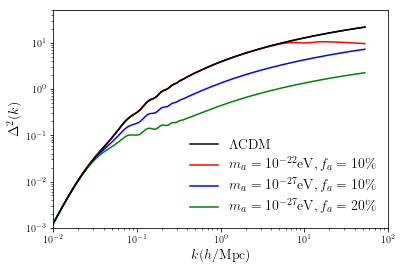

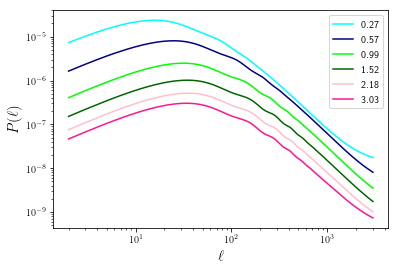

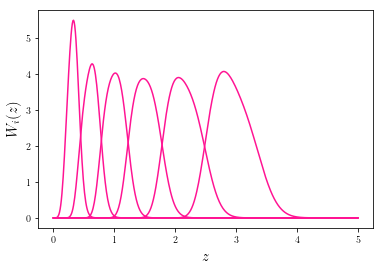

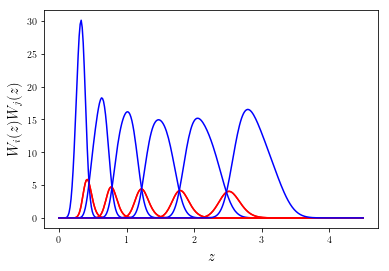

In [26]:
plt.loglog(k[2][0][0][0],pk_dimless[2][0][0][0],color = 'k',label = r'$\Lambda {\rm CDM}$')
plt.loglog(k[2][10][4][0],pk_dimless[2][10][4][0],color = 'r',label = r'$m_a = 10^{-22}{\rm eV}, f_a = 10\%$')
plt.loglog(k[2][3][4][0],pk_dimless[2][3][4][0],color = 'b',label = r'$m_a = 10^{-27}{\rm eV}, f_a = 10\%$')
plt.loglog(k[2][3][8][0],pk_dimless[2][3][8][0],color = 'g',label = r'$m_a = 10^{-27}{\rm eV}, f_a = 20\%$')
plt.loglog(k[2][0][0][0],pk_dimless[2][0][0][0],color = 'k')
plt.legend(frameon = False,loc = 'lower right',fontsize = 14)
plt.xlabel(r'$k (h/{\rm Mpc})$',size = 14)
plt.ylabel(r'$\Delta^2(k)$',size = 14)
plt.xlim(0.01,100)
plt.ylim(0.001,50)
plt.show()
plt.close('all')

plt.plot(lgoal,Pl[0][0][0][0][0],color = 'cyan',label = zavg[0])
plt.plot(lgoal,Pl[0][0][0][1][1],color = 'navy',label = zavg[1])
plt.plot(lgoal,Pl[0][0][0][2][2]/2,color = 'lime',label = zavg[2])
plt.plot(lgoal,Pl[0][0][0][3][3]/4,color = 'darkgreen',label = zavg[3])
plt.plot(lgoal,Pl[0][0][0][4][4]/8,color = 'pink',label = zavg[4])
plt.plot(lgoal,Pl[0][0][0][5][5]/16,color = 'deeppink',label = zavg[5])
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$\ell$',size = 15)
plt.ylabel(r'$P(\ell)$',size = 15)
plt.legend()
plt.show()
plt.close('all')

for i in range(len(zavg)):
    plt.plot(zlist,window[i],color = 'deeppink')
plt.xlabel(r'$z$',size = 15)
plt.ylabel(r'$W_i(z)$',size = 15)
plt.show()
plt.close('all')

for i in range(len(zavg)):
    for j in range(len(zavg)):
        if i == j:
            plt.plot(zlist_camb,correlated_windows[i][j],color = 'b')
        else:
            plt.plot(zlist_camb,correlated_windows[i][j],color = 'r')
plt.xlabel(r'$z$',size = 15)
plt.ylabel(r'$W_i(z)W_j(z)$',size = 15)
plt.show()
plt.close('all')